In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
import pandas as pd
import DatasetGenerator as DG
DG.generate()
pd.options.display.max_rows = 9999
df = pd.read_csv('in_out.csv')

DG.train_splitter(0.7)

[10, 'C:\\Users\\Ante\\Documents\\Faks\\neuronske\\VineClass\\dataset\\Grape\\Grape___Black_rot\\ba8af5e5-aadb-41f5-b08d-6d8c8cdce302___FAM_B.Rot 0513.JPG', 'blackrot']


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cooked_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


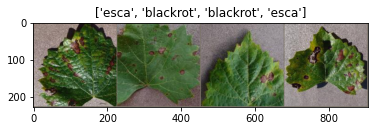

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
import datetime

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print(datetime.datetime.now())
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
2022-12-29 18:44:43.227676
----------
train Loss: 2.0642 Acc: 0.4174
val Loss: 2.9157 Acc: 0.5673

Epoch 1/24
2022-12-29 18:45:19.761534
----------
train Loss: 1.3138 Acc: 0.4873
val Loss: 1.5782 Acc: 0.5747

Epoch 2/24
2022-12-29 18:45:51.591615
----------
train Loss: 1.0909 Acc: 0.5278
val Loss: 0.7112 Acc: 0.7176

Epoch 3/24
2022-12-29 18:46:23.322812
----------
train Loss: 0.9104 Acc: 0.6276
val Loss: 1.5463 Acc: 0.6847

Epoch 4/24
2022-12-29 18:46:55.058906
----------
train Loss: 0.7704 Acc: 0.6839
val Loss: 0.5306 Acc: 0.7989

Epoch 5/24
2022-12-29 18:47:27.188172
----------
train Loss: 0.6681 Acc: 0.7278
val Loss: 0.3932 Acc: 0.8522

Epoch 6/24
2022-12-29 18:47:58.900749
----------
train Loss: 0.5861 Acc: 0.7669
val Loss: 0.4055 Acc: 0.8547

Epoch 7/24
2022-12-29 18:48:30.689982
----------
train Loss: 0.4266 Acc: 0.8400
val Loss: 0.3200 Acc: 0.8916

Epoch 8/24
2022-12-29 18:49:02.590648
----------
train Loss: 0.4033 Acc: 0.8446
val Loss: 0.2655 Acc: 0.9163

Epoch 9/24

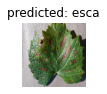

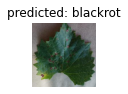

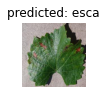

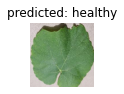

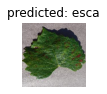

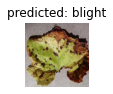

In [38]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
2022-12-29 18:58:13.902179
----------
train Loss: 2.7408 Acc: 0.7032
val Loss: 1.5958 Acc: 0.8637

Epoch 1/24
2022-12-29 18:58:35.837539
----------
train Loss: 2.5808 Acc: 0.7785
val Loss: 0.4908 Acc: 0.9425

Epoch 2/24
2022-12-29 18:58:57.742289
----------
train Loss: 3.1914 Acc: 0.7785
val Loss: 0.7811 Acc: 0.9130

Epoch 3/24
2022-12-29 18:59:19.606425
----------
train Loss: 2.5381 Acc: 0.8052
val Loss: 0.7099 Acc: 0.9228

Epoch 4/24
2022-12-29 18:59:41.678378
----------
train Loss: 3.2237 Acc: 0.7925
val Loss: 1.1146 Acc: 0.9056

Epoch 5/24
2022-12-29 19:00:03.780277
----------
train Loss: 2.4238 Acc: 0.8231
val Loss: 0.5933 Acc: 0.9433

Epoch 6/24
2022-12-29 19:00:25.670053
----------
train Loss: 2.7695 Acc: 0.7978
val Loss: 2.1596 Acc: 0.8498

Epoch 7/24
2022-12-29 19:00:49.204488
----------
train Loss: 1.6639 Acc: 0.8565
val Loss: 0.5327 Acc: 0.9442

Epoch 8/24
2022-12-29 19:01:11.178399
----------
train Loss: 1.3949 Acc: 0.8738
val Loss: 0.4413 Acc: 0.9491

Epoch 9/24

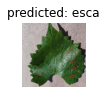

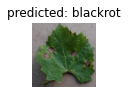

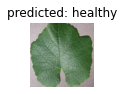

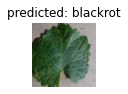

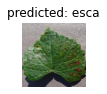

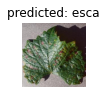

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()